# An example of many-to-one (sequence classification)

Original experiment from [Hochreiter & Schmidhuber (1997)](www.bioinf.jku.at/publications/older/2604.pdf).

The goal is to classify sequences.
Elements and targets are represented locally (input vectors with only one non-zero bit).
The sequence starts with an `B`, ends with a `E` (the “trigger symbol”), and otherwise consists of randomly chosen symbols from the set `{a, b, c, d}` except for two elements at positions `t1` and `t2` that are either `X` or `Y`.
For the `DifficultyLevel.HARD` case, the sequence length is randomly chosen between `100` and `110`, `t1` is randomly chosen between `10` and `20`, and `t2` is randomly chosen between `50` and `60`.
There are `4` sequence classes `Q`, `R`, `S`, and `U`, which depend on the temporal order of `X` and `Y`.

The rules are:

```
X, X -> Q,
X, Y -> R,
Y, X -> S,
Y, Y -> U.
```

## 1. Dataset Exploration

In [5]:
# --- ensure 'res' package is available (from Atcold/pytorch-Deep-Learning) ---
import os, sys, subprocess, shutil

def ensure_res():
    if os.path.isdir('res'):
        return
    try:
        subprocess.check_call(['git', 'clone', '--depth', '1',
                               'https://github.com/Atcold/pytorch-Deep-Learning.git'])
        shutil.copytree('pytorch-Deep-Learning/res', 'res', dirs_exist_ok=True)
        sys.path.append('.')
    except Exception as e:
        raise ImportError("Could not fetch 'res' folder automatically. "
                          "Either comment out QRSU usage or add 'res' manually.") from e

ensure_res()
from res.sequential_tasks import TemporalOrderExp6aSequence as QRSU

In [6]:
# Create a data generator
example_generator = QRSU.get_predefined_generator(
    difficulty_level=QRSU.DifficultyLevel.EASY,
    batch_size=32,
)

example_batch = example_generator[1]
print(f'The return type is a {type(example_batch)} with length {len(example_batch)}.')
print(f'The first item in the tuple is the batch of sequences with shape {example_batch[0].shape}.')
print(f'The first element in the batch of sequences is:\n {example_batch[0][0, :, :]}')
print(f'The second item in the tuple is the corresponding batch of class labels with shape {example_batch[1].shape}.')
print(f'The first element in the batch of class labels is:\n {example_batch[1][0, :]}')

The return type is a <class 'tuple'> with length 2.
The first item in the tuple is the batch of sequences with shape (32, 9, 8).
The first element in the batch of sequences is:
 [[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1]]
The second item in the tuple is the corresponding batch of class labels with shape (32, 4).
The first element in the batch of class labels is:
 [1. 0. 0. 0.]


In [7]:
# Decoding the first sequence
sequence_decoded = example_generator.decode_x(example_batch[0][0, :, :])
print(f'The sequence is: {sequence_decoded}')

# Decoding the class label of the first sequence
class_label_decoded = example_generator.decode_y(example_batch[1][0])
print(f'The class label is: {class_label_decoded}')

The sequence is: BbXcXcbE
The class label is: Q


## 2. Defining the Model

In [8]:
import torch
import torch.nn as nn

# Set the random seed for reproducible results
torch.manual_seed(1)

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        # This just calls the base class constructor
        super().__init__()
        # Neural network layers assigned as attributes of a Module subclass
        # have their parameters registered for training automatically.
        self.rnn = torch.nn.RNN(input_size, hidden_size, nonlinearity='relu', batch_first=True)
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # The RNN also returns its hidden state but we don't use it.
        # While the RNN can also take a hidden state as input, the RNN
        # gets passed a hidden state initialized with zeros by default.
        h = self.rnn(x)[0]
        x = self.linear(h)
        return x

class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h = self.lstm(x)[0]
        x = self.linear(h)
        return x

    def get_states_across_time(self, x):
        h_c = None
        h_list, c_list = list(), list()
        with torch.no_grad():
            for t in range(x.size(1)):
                h_c = self.lstm(x[:, [t], :], h_c)[1]
                h_list.append(h_c[0])
                c_list.append(h_c[1])
            h = torch.cat(h_list)
            c = torch.cat(c_list)
        return h, c

## 3. Defining the Training Loop

In [9]:
def train(model, train_data_gen, criterion, optimizer, device, max_grad_norm=0.5):
    # Set the model to training mode. This will turn on layers that would
    # otherwise behave differently during evaluation, such as dropout.
    model.train()

    # Store the number of sequences that were classified correctly
    num_correct = 0
    total_loss = 0.0
    num_batches = 0

    # Iterate over every batch of sequences. Note that the length of a data generator
    # is defined as the number of batches required to produce a total of roughly 1000
    # sequences given a batch size.
    for batch_idx in range(len(train_data_gen)):

        # Request a batch of sequences and class labels, convert them into tensors
        # of the correct type, and then send them to the appropriate device.
        data, target = train_data_gen[batch_idx]
        data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

        # Perform the forward pass of the model
        output = model(data)  # Step ①

        # Pick only the output corresponding to last sequence element (input is pre padded)
        output = output[:, -1, :]

        # Compute the value of the loss for this batch. For loss functions like CrossEntropyLoss,
        # the second argument is actually expected to be a tensor of class indices rather than
        # one-hot encoded class labels. One approach is to take advantage of the one-hot encoding
        # of the target and call argmax along its second dimension to create a tensor of shape
        # (batch_size) containing the index of the class label that was hot for each sequence.
        target = target.argmax(dim=1)

        loss = criterion(output, target)  # Step ②

        # Check for NaN or extremely large loss values to prevent spikes
        if torch.isnan(loss) or loss.item() > 10.0:
            print(f"Warning: Skipping batch {batch_idx} due to extreme loss: {loss.item()}")
            continue

        # Clear the gradient buffers of the optimized parameters.
        # Otherwise, gradients from the previous batch would be accumulated.
        optimizer.zero_grad()  # Step ③

        loss.backward()  # Step ④

        # More aggressive gradient clipping to prevent gradient explosion and reduce spikes
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        # Check for NaN gradients and skip update if found
        has_nan_grad = False
        for param in model.parameters():
            if param.grad is not None and torch.isnan(param.grad).any():
                has_nan_grad = True
                break

        if not has_nan_grad:
            optimizer.step()  # Step ⑤
        else:
            print(f"Warning: Skipping optimizer step due to NaN gradients in batch {batch_idx}")

        y_pred = output.argmax(dim=1)
        num_correct += (y_pred == target).sum().item()
        total_loss += loss.item()
        num_batches += 1

    return num_correct, total_loss / max(num_batches, 1)

## 4. Defining the Testing Loop

In [10]:
def test(model, test_data_gen, criterion, device):
    # Set the model to evaluation mode. This will turn off layers that would
    # otherwise behave differently during training, such as dropout.
    model.eval()

    # Store the number of sequences that were classified correctly
    num_correct = 0

    # A context manager is used to disable gradient calculations during inference
    # to reduce memory usage, as we typically don't need the gradients at this point.
    with torch.no_grad():
        for batch_idx in range(len(test_data_gen)):
            data, target = test_data_gen[batch_idx]
            data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

            output = model(data)
            # Pick only the output corresponding to last sequence element (input is pre padded)
            output = output[:, -1, :]

            target = target.argmax(dim=1)
            loss = criterion(output, target)

            y_pred = output.argmax(dim=1)
            num_correct += (y_pred == target).sum().item()

    return num_correct, loss.item()

## 5. Putting it All Together

In [11]:
import matplotlib.pyplot as plt
from res.plot_lib import set_default, plot_state, print_colourbar

In [12]:
set_default()

In [13]:
def train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs, verbose=True, max_grad_norm=0.5, scheduler=None):
    # Automatically determine the device that PyTorch should use for computation
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    # Move model to the device which will be used for train and test
    model.to(device)

    # Track the value of the loss function and model accuracy across epochs
    history_train = {'loss': [], 'acc': []}
    history_test = {'loss': [], 'acc': []}

    # Exponential moving average for smoothing training curves
    train_loss_ema = None
    test_loss_ema = None
    ema_alpha = 0.9

    for epoch in range(max_epochs):
        # Run the training loop and calculate the accuracy.
        # Remember that the length of a data generator is the number of batches,
        # so we multiply it by the batch size to recover the total number of sequences.
        num_correct, loss = train(model, train_data_gen, criterion, optimizer, device, max_grad_norm)
        accuracy = float(num_correct) / (len(train_data_gen) * train_data_gen.batch_size) * 100

        # Apply exponential moving average to smooth the loss
        if train_loss_ema is None:
            train_loss_ema = loss
        else:
            train_loss_ema = ema_alpha * train_loss_ema + (1 - ema_alpha) * loss

        history_train['loss'].append(train_loss_ema)
        history_train['acc'].append(accuracy)

        # Do the testing loop
        num_correct, loss = test(model, test_data_gen, criterion, device)
        accuracy = float(num_correct) / (len(test_data_gen) * test_data_gen.batch_size) * 100

        # Apply exponential moving average to smooth the test loss
        if test_loss_ema is None:
            test_loss_ema = loss
        else:
            test_loss_ema = ema_alpha * test_loss_ema + (1 - ema_alpha) * loss

        history_test['loss'].append(test_loss_ema)
        history_test['acc'].append(accuracy)

        # Step the learning rate scheduler if provided (for ReduceLROnPlateau, step with validation loss)
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(test_loss_ema)  # Use the smoothed test loss for more stable scheduling
            else:
                scheduler.step()

        if verbose or epoch + 1 == max_epochs:
            current_lr = optimizer.param_groups[0]['lr']
            print(f'[Epoch {epoch + 1}/{max_epochs}]'
                  f" loss: {history_train['loss'][-1]:.4f}, acc: {history_train['acc'][-1]:2.2f}%"
                  f" - test_loss: {history_test['loss'][-1]:.4f}, test_acc: {history_test['acc'][-1]:2.2f}%"
                  f" - lr: {current_lr:.6f}")

    # Generate diagnostic plots for the loss and accuracy
    fig, axes = plt.subplots(ncols=2, figsize=(9, 4.5))
    for ax, metric in zip(axes, ['loss', 'acc']):
        ax.plot(history_train[metric])
        ax.plot(history_test[metric])
        ax.set_xlabel('epoch', fontsize=12)
        ax.set_ylabel(metric, fontsize=12)
        ax.legend(['Train', 'Test'], loc='best')
    plt.show()

    return model

## 5. Simple RNN: 10 Epochs

[Epoch 1/10] loss: 1.3942, acc: 24.29% - test_loss: 1.3710, test_acc: 31.35% - lr: 0.001000
[Epoch 2/10] loss: 1.3931, acc: 30.75% - test_loss: 1.3723, test_acc: 37.50% - lr: 0.001000
[Epoch 3/10] loss: 1.3917, acc: 40.22% - test_loss: 1.3742, test_acc: 40.12% - lr: 0.001000
[Epoch 4/10] loss: 1.3893, acc: 39.82% - test_loss: 1.3711, test_acc: 43.85% - lr: 0.001000
[Epoch 5/10] loss: 1.3836, acc: 44.35% - test_loss: 1.3669, test_acc: 37.00% - lr: 0.001000
[Epoch 6/10] loss: 1.3738, acc: 40.32% - test_loss: 1.3545, test_acc: 40.83% - lr: 0.001000
[Epoch 7/10] loss: 1.3608, acc: 43.95% - test_loss: 1.3459, test_acc: 47.58% - lr: 0.001000
[Epoch 8/10] loss: 1.3436, acc: 50.30% - test_loss: 1.3364, test_acc: 47.78% - lr: 0.001000
[Epoch 9/10] loss: 1.3247, acc: 48.59% - test_loss: 1.3148, test_acc: 50.81% - lr: 0.001000
[Epoch 10/10] loss: 1.3031, acc: 48.69% - test_loss: 1.2914, test_acc: 49.29% - lr: 0.001000


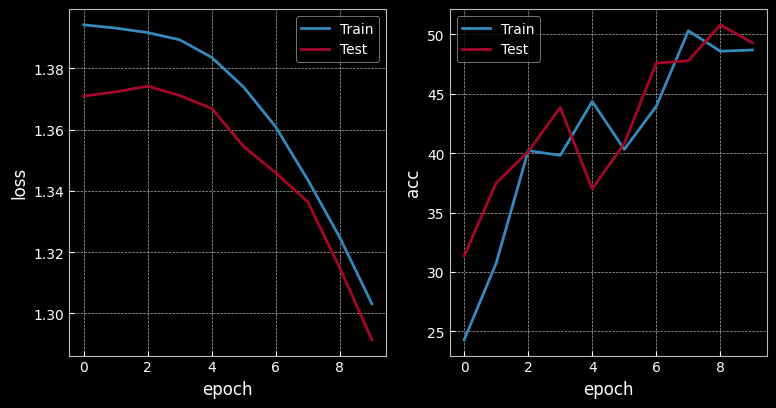

In [14]:
# Setup the training and test data generators
difficulty     = QRSU.DifficultyLevel.EASY
batch_size     = 32
train_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)
test_data_gen  = QRSU.get_predefined_generator(difficulty, batch_size)

# Setup the RNN and training settings
input_size  = train_data_gen.n_symbols
hidden_size = 4
output_size = train_data_gen.n_classes
model       = SimpleRNN(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 10

# Train the model
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs)

In [15]:
for parameter_group in list(model.parameters()):
    print(parameter_group.size())

torch.Size([4, 8])
torch.Size([4, 4])
torch.Size([4])
torch.Size([4])
torch.Size([4, 4])
torch.Size([4])


## 5. Simple LSTM: 10 Epochs

[Epoch 1/10] loss: 1.3947, acc: 32.66% - test_loss: 1.4515, test_acc: 29.03% - lr: 0.001000
[Epoch 2/10] loss: 1.3932, acc: 28.02% - test_loss: 1.4463, test_acc: 26.01% - lr: 0.001000
[Epoch 3/10] loss: 1.3902, acc: 37.40% - test_loss: 1.4358, test_acc: 50.71% - lr: 0.001000
[Epoch 4/10] loss: 1.3819, acc: 49.29% - test_loss: 1.4199, test_acc: 52.12% - lr: 0.001000
[Epoch 5/10] loss: 1.3674, acc: 48.59% - test_loss: 1.3954, test_acc: 50.50% - lr: 0.001000
[Epoch 6/10] loss: 1.3469, acc: 56.35% - test_loss: 1.3652, test_acc: 71.98% - lr: 0.001000
[Epoch 7/10] loss: 1.3216, acc: 77.02% - test_loss: 1.3365, test_acc: 80.14% - lr: 0.001000
[Epoch 8/10] loss: 1.2921, acc: 82.06% - test_loss: 1.3123, test_acc: 90.12% - lr: 0.001000
[Epoch 9/10] loss: 1.2593, acc: 95.56% - test_loss: 1.2746, test_acc: 99.70% - lr: 0.001000
[Epoch 10/10] loss: 1.2220, acc: 98.99% - test_loss: 1.2328, test_acc: 99.90% - lr: 0.001000


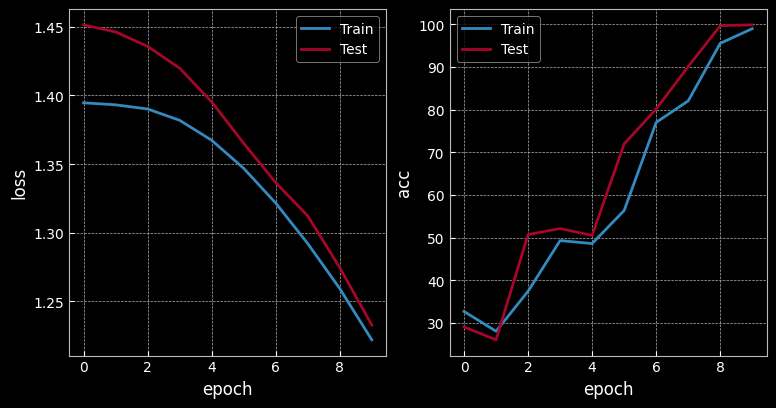

In [16]:
# Setup the training and test data generators
difficulty     = QRSU.DifficultyLevel.EASY
batch_size     = 32
train_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)
test_data_gen  = QRSU.get_predefined_generator(difficulty, batch_size)

# Setup the RNN and training settings
input_size  = train_data_gen.n_symbols
hidden_size = 4
output_size = train_data_gen.n_classes
model       = SimpleLSTM(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 10

# Train the model
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs)

In [17]:
for parameter_group in list(model.parameters()):
    print(parameter_group.size())

torch.Size([16, 8])
torch.Size([16, 4])
torch.Size([16])
torch.Size([16])
torch.Size([4, 4])
torch.Size([4])


## 6. RNN: Increasing Epoch to 100

[Epoch 100/100] loss: 0.0028, acc: 100.00% - test_loss: 0.0027, test_acc: 100.00% - lr: 0.001000


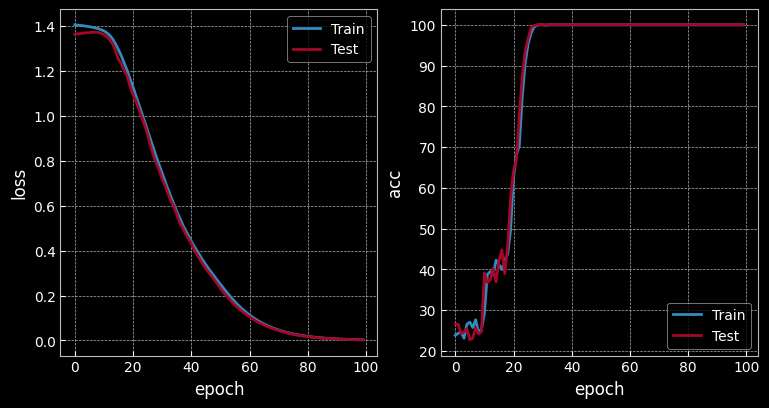

In [19]:
# Setup the training and test data generators
difficulty     = QRSU.DifficultyLevel.EASY
batch_size     = 32
train_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)
test_data_gen  = QRSU.get_predefined_generator(difficulty, batch_size)

# Setup the RNN and training settings
input_size  = train_data_gen.n_symbols
hidden_size = 4
output_size = train_data_gen.n_classes
model       = SimpleRNN(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
# Add learning rate scheduler for stable training
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
max_epochs  = 100

# Train the model with gradient clipping and learning rate scheduling
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs, verbose=False, max_grad_norm=1.0, scheduler=scheduler)

## LSTM: Increasing Epoch to 100

[Epoch 100/100] loss: 0.0031, acc: 100.00% - test_loss: 0.0030, test_acc: 100.00% - lr: 0.001000


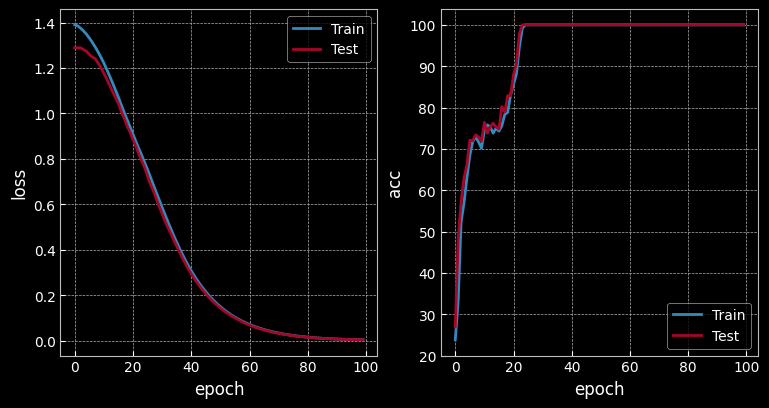

In [20]:
# Setup the training and test data generators
difficulty     = QRSU.DifficultyLevel.EASY
batch_size     = 32
train_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)
test_data_gen  = QRSU.get_predefined_generator(difficulty, batch_size)

# Setup the RNN and training settings
input_size  = train_data_gen.n_symbols
hidden_size = 4
output_size = train_data_gen.n_classes
model       = SimpleLSTM(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
# Add learning rate scheduler for stable training
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
max_epochs  = 100

# Train the model with gradient clipping and learning rate scheduling
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs, verbose=False, max_grad_norm=1.0, scheduler=scheduler)

## 7. Model Evaluation

In [21]:
import collections
import random

def evaluate_model(model, difficulty, seed=9001, verbose=False):
    # Define a dictionary that maps class indices to labels
    class_idx_to_label = {0: 'Q', 1: 'R', 2: 'S', 3: 'U'}

    # Create a new data generator
    data_generator = QRSU.get_predefined_generator(difficulty, seed=seed)

    # Track the number of times a class appears
    count_classes = collections.Counter()

    # Keep correctly classified and misclassified sequences, and their
    # true and predicted class labels, for diagnostic information.
    correct = []
    incorrect = []

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    model.eval()

    with torch.no_grad():
        for batch_idx in range(len(data_generator)):
            data, target = test_data_gen[batch_idx]
            data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

            data_decoded = data_generator.decode_x_batch(data.cpu().numpy())
            target_decoded = data_generator.decode_y_batch(target.cpu().numpy())

            output = model(data)
            output = output[:, -1, :]

            target = target.argmax(dim=1)
            y_pred = output.argmax(dim=1)
            y_pred_decoded = [class_idx_to_label[y.item()] for y in y_pred]

            count_classes.update(target_decoded)
            for i, (truth, prediction) in enumerate(zip(target_decoded, y_pred_decoded)):
                if truth == prediction:
                    correct.append((data_decoded[i], truth, prediction))
                else:
                    incorrect.append((data_decoded[i], truth, prediction))

    num_sequences = sum(count_classes.values())
    accuracy = float(len(correct)) / num_sequences * 100
    print(f'The accuracy of the model is measured to be {accuracy:.2f}%.\n')

    # Report the accuracy by class
    for label in sorted(count_classes):
        num_correct = sum(1 for _, truth, _ in correct if truth == label)
        print(f'{label}: {num_correct} / {count_classes[label]} correct')

    # Report some random sequences for examination
    print('\nHere are some example sequences:')
    for i in range(10):
        sequence, truth, prediction = correct[random.randrange(0, 10)]
        print(f'{sequence} -> {truth} was labelled {prediction}')

    # Report misclassified sequences for investigation
    if incorrect and verbose:
        print('\nThe following sequences were misclassified:')
        for sequence, truth, prediction in incorrect:
            print(f'{sequence} -> {truth} was labelled {prediction}')
    else:
        print('\nThere were no misclassified sequences.')

In [22]:
evaluate_model(model, difficulty)

The accuracy of the model is measured to be 100.00%.

Q: 258 / 258 correct
R: 249 / 249 correct
S: 232 / 232 correct
U: 253 / 253 correct

Here are some example sequences:
BbXaXdE -> Q was labelled Q
BbXcXbcE -> Q was labelled Q
BYdcaYbE -> U was labelled U
BbXaXdE -> Q was labelled Q
BbXcXbcE -> Q was labelled Q
BYbdYabE -> U was labelled U
BdYcbXE -> S was labelled S
BbXaXdE -> Q was labelled Q
BdYcbXE -> S was labelled S
BdYcbXE -> S was labelled S

There were no misclassified sequences.


## 8. Visualize LSTM
Setting difficulty to `MODERATE` and `hidden_size` to 12.

[Epoch 100/100] loss: 0.0198, acc: 100.00% - test_loss: 0.0384, test_acc: 100.00% - lr: 0.000120


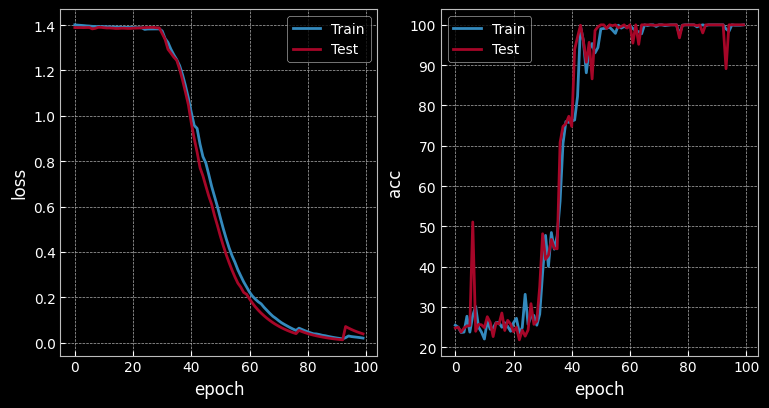

In [24]:
# For reproducibility
torch.manual_seed(1)

# Setup the training and test data generators
difficulty     = QRSU.DifficultyLevel.MODERATE
batch_size     = 32
train_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)
test_data_gen  = QRSU.get_predefined_generator(difficulty, batch_size)

# Setup the RNN and training settings
input_size  = train_data_gen.n_symbols
hidden_size = 12
output_size = train_data_gen.n_classes
model       = SimpleLSTM(input_size, hidden_size, output_size)
criterion   = torch.nn.CrossEntropyLoss()
# Use more conservative optimizer settings with weight decay for stability
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.0005, weight_decay=1e-5, momentum=0.9)
# More aggressive learning rate scheduler for stable training
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=5, min_lr=1e-6)
max_epochs  = 100

# Train the model with enhanced stability measures
model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs, verbose=False, max_grad_norm=0.5, scheduler=scheduler)

In [25]:
# Get hidden (H) and cell (C) batch state given a batch input (X)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.eval()
with torch.no_grad():
    data = test_data_gen[0][0]
    X = torch.from_numpy(data).float().to(device)
    H_t, C_t = model.get_states_across_time(X)

In [ ]:
print("Color range is as follows:")
print_colourbar()

In [26]:
plot_state(X.cpu(), C_t, b=9, decoder=test_data_gen.decode_x)  # 3, 6, 9

In [27]:
plot_state(X.cpu(), H_t, b=9, decoder=test_data_gen.decode_x)

## 9. Gradient and Weight Visualization (Extra Credit)

Visualizing the gradients and weights throughout training to see the difference between the original and improved training procedures.


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

class TrainingTracker:
    def __init__(self):
        self.gradient_norms = defaultdict(list)
        self.weight_norms = defaultdict(list)
        self.layer_gradients = defaultdict(list)
        self.layer_weights = defaultdict(list)
        self.epochs = []

    def track_gradients(self, model, epoch):
        """Track gradient norms and individual layer gradients"""
        self.epochs.append(epoch)
        total_grad_norm = 0.0

        for name, param in model.named_parameters():
            if param.grad is not None:
                grad_norm = param.grad.data.norm(2).item()
                self.gradient_norms[name].append(grad_norm)
                self.layer_gradients[name].append(param.grad.data.clone())
                total_grad_norm += grad_norm ** 2

        total_grad_norm = total_grad_norm ** 0.5
        self.gradient_norms['total'].append(total_grad_norm)

    def track_weights(self, model, epoch):
        """Track weight norms and individual layer weights"""
        total_weight_norm = 0.0

        for name, param in model.named_parameters():
            weight_norm = param.data.norm(2).item()
            self.weight_norms[name].append(weight_norm)
            self.layer_weights[name].append(param.data.clone())
            total_weight_norm += weight_norm ** 2

        total_weight_norm = total_weight_norm ** 0.5
        self.weight_norms['total'].append(total_weight_norm)

def train_with_tracking(model, train_data_gen, criterion, optimizer, device, tracker, max_grad_norm=None):
    """Original training function with gradient/weight tracking"""
    model.train()
    num_correct = 0

    for batch_idx in range(len(train_data_gen)):
        data, target = train_data_gen[batch_idx]
        data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

        output = model(data)
        output = output[:, -1, :]
        target = target.argmax(dim=1)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()

        # Track gradients before clipping (if any)
        if batch_idx == 0:  # Track only first batch of each epoch for efficiency
            tracker.track_gradients(model, len(tracker.epochs))
            tracker.track_weights(model, len(tracker.epochs))

        # Apply gradient clipping if specified
        if max_grad_norm is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()

        y_pred = output.argmax(dim=1)
        num_correct += (y_pred == target).sum().item()

    return num_correct, loss.item()

def train_and_test_with_tracking(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs, tracker, max_grad_norm=None, scheduler=None):
    """Training function with comprehensive tracking"""
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    history_train = {'loss': [], 'acc': []}
    history_test = {'loss': [], 'acc': []}

    for epoch in range(max_epochs):
        # Training
        num_correct, loss = train_with_tracking(model, train_data_gen, criterion, optimizer, device, tracker, max_grad_norm)
        accuracy = float(num_correct) / (len(train_data_gen) * train_data_gen.batch_size) * 100
        history_train['loss'].append(loss)
        history_train['acc'].append(accuracy)

        # Testing
        num_correct, loss = test(model, test_data_gen, criterion, device)
        accuracy = float(num_correct) / (len(test_data_gen) * test_data_gen.batch_size) * 100
        history_test['loss'].append(loss)
        history_test['acc'].append(accuracy)

        # Learning rate scheduling
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(loss)
            else:
                scheduler.step()

        if epoch % 10 == 0 or epoch == max_epochs - 1:
            print(f'[Epoch {epoch + 1}/{max_epochs}]'
                  f" loss: {history_train['loss'][-1]:.4f}, acc: {history_train['acc'][-1]:2.2f}%"
                  f" - test_loss: {history_test['loss'][-1]:.4f}, test_acc: {history_test['acc'][-1]:2.2f}%")

    return model, history_train, history_test


In [29]:
# Train with ORIGINAL procedure (no stability measures)
print("=== Training with ORIGINAL procedure ===")
torch.manual_seed(1)  # Same seed for fair comparison

# Setup data
difficulty = QRSU.DifficultyLevel.MODERATE
batch_size = 32
train_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)
test_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)

# Setup model with original settings
input_size = train_data_gen.n_symbols
hidden_size = 12
output_size = train_data_gen.n_classes
model_original = SimpleLSTM(input_size, hidden_size, output_size)
criterion = torch.nn.CrossEntropyLoss()
optimizer_original = torch.optim.RMSprop(model_original.parameters(), lr=0.001)  # Original settings
max_epochs = 100

# Track gradients and weights
tracker_original = TrainingTracker()

# Train with original procedure (no gradient clipping, no scheduler)
model_original, history_original_train, history_original_test = train_and_test_with_tracking(
    model_original, train_data_gen, test_data_gen, criterion, optimizer_original,
    max_epochs, tracker_original, max_grad_norm=None, scheduler=None
)


=== Training with ORIGINAL procedure ===
[Epoch 1/100] loss: 1.3896, acc: 23.69% - test_loss: 1.3813, test_acc: 25.30%
[Epoch 11/100] loss: 1.3865, acc: 27.62% - test_loss: 1.3817, test_acc: 31.25%
[Epoch 21/100] loss: 0.8380, acc: 76.92% - test_loss: 0.6481, test_acc: 87.30%
[Epoch 31/100] loss: 1.3994, acc: 24.09% - test_loss: 1.3840, test_acc: 25.10%
[Epoch 41/100] loss: 0.9637, acc: 48.59% - test_loss: 0.8520, test_acc: 68.85%
[Epoch 51/100] loss: 0.5196, acc: 88.61% - test_loss: 0.4084, test_acc: 89.62%
[Epoch 61/100] loss: 0.2446, acc: 97.28% - test_loss: 0.2409, test_acc: 97.58%
[Epoch 71/100] loss: 0.0465, acc: 99.50% - test_loss: 0.0525, test_acc: 99.09%
[Epoch 81/100] loss: 0.0288, acc: 100.00% - test_loss: 0.0293, test_acc: 100.00%
[Epoch 91/100] loss: 0.1770, acc: 95.16% - test_loss: 0.0316, test_acc: 96.17%
[Epoch 100/100] loss: 2.3904, acc: 95.56% - test_loss: 1.9948, test_acc: 66.03%


In [31]:
# Train with IMPROVED procedure (with stability measures)
print("\n=== Training with IMPROVED procedure ===")
torch.manual_seed(1)  # Same seed for fair comparison

# Setup data (same as before)
difficulty = QRSU.DifficultyLevel.MODERATE
batch_size = 32
train_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)
test_data_gen = QRSU.get_predefined_generator(difficulty, batch_size)

# Setup model with improved settings
input_size = train_data_gen.n_symbols
hidden_size = 12
output_size = train_data_gen.n_classes
model_improved = SimpleLSTM(input_size, hidden_size, output_size)
criterion = torch.nn.CrossEntropyLoss()
# Improved optimizer settings
optimizer_improved = torch.optim.RMSprop(model_improved.parameters(), lr=0.0005, weight_decay=1e-5, momentum=0.9)
# Improved scheduler
scheduler_improved = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_improved, mode='min', factor=0.7, patience=5, min_lr=1e-6)
max_epochs = 100

# Track gradients and weights
tracker_improved = TrainingTracker()

# Train with improved procedure (gradient clipping + scheduler)
model_improved, history_improved_train, history_improved_test = train_and_test_with_tracking(
    model_improved, train_data_gen, test_data_gen, criterion, optimizer_improved,
    max_epochs, tracker_improved, max_grad_norm=0.5, scheduler=scheduler_improved
)



=== Training with IMPROVED procedure ===
[Epoch 1/100] loss: 1.3878, acc: 25.50% - test_loss: 1.3892, test_acc: 24.80%
[Epoch 11/100] loss: 1.3980, acc: 22.08% - test_loss: 1.3730, test_acc: 24.90%
[Epoch 21/100] loss: 1.3780, acc: 26.11% - test_loss: 1.3938, test_acc: 23.89%
[Epoch 31/100] loss: 1.1927, acc: 38.51% - test_loss: 1.1375, test_acc: 48.19%
[Epoch 41/100] loss: 0.4616, acc: 76.11% - test_loss: 0.2502, test_acc: 74.80%
[Epoch 51/100] loss: 0.0541, acc: 98.99% - test_loss: 0.0498, test_acc: 100.00%
[Epoch 61/100] loss: 0.0097, acc: 99.80% - test_loss: 0.0085, test_acc: 100.00%
[Epoch 71/100] loss: 0.0030, acc: 100.00% - test_loss: 0.0046, test_acc: 100.00%
[Epoch 81/100] loss: 0.0019, acc: 100.00% - test_loss: 0.0017, test_acc: 100.00%
[Epoch 91/100] loss: 0.0014, acc: 100.00% - test_loss: 0.0018, test_acc: 100.00%
[Epoch 100/100] loss: 0.0007, acc: 100.00% - test_loss: 0.0011, test_acc: 100.00%


In [32]:
def plot_gradient_analysis(tracker_original, tracker_improved):
    """Plot comprehensive gradient analysis comparing original vs improved training"""

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Gradient Analysis: Original vs Improved Training', fontsize=16, fontweight='bold')

    epochs_orig = tracker_original.epochs
    epochs_improved = tracker_improved.epochs

    # 1. Total gradient norm comparison
    ax = axes[0, 0]
    ax.plot(epochs_orig, tracker_original.gradient_norms['total'], 'r-', label='Original', linewidth=2)
    ax.plot(epochs_improved, tracker_improved.gradient_norms['total'], 'b-', label='Improved', linewidth=2)
    ax.set_title('Total Gradient Norm Over Time')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Gradient Norm')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')

    # 2. LSTM weight gradients
    ax = axes[0, 1]
    lstm_weight_key = 'lstm.weight_ih_l0'  # LSTM input-to-hidden weights
    if lstm_weight_key in tracker_original.gradient_norms and lstm_weight_key in tracker_improved.gradient_norms:
        ax.plot(epochs_orig, tracker_original.gradient_norms[lstm_weight_key], 'r-', label='Original', linewidth=2)
        ax.plot(epochs_improved, tracker_improved.gradient_norms[lstm_weight_key], 'b-', label='Improved', linewidth=2)
    ax.set_title('LSTM Input-Weight Gradients')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Gradient Norm')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')

    # 3. LSTM hidden gradients
    ax = axes[0, 2]
    lstm_hidden_key = 'lstm.weight_hh_l0'  # LSTM hidden-to-hidden weights
    if lstm_hidden_key in tracker_original.gradient_norms and lstm_hidden_key in tracker_improved.gradient_norms:
        ax.plot(epochs_orig, tracker_original.gradient_norms[lstm_hidden_key], 'r-', label='Original', linewidth=2)
        ax.plot(epochs_improved, tracker_improved.gradient_norms[lstm_hidden_key], 'b-', label='Improved', linewidth=2)
    ax.set_title('LSTM Hidden-Weight Gradients')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Gradient Norm')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')

    # 4. Linear layer gradients
    ax = axes[1, 0]
    linear_key = 'linear.weight'
    if linear_key in tracker_original.gradient_norms and linear_key in tracker_improved.gradient_norms:
        ax.plot(epochs_orig, tracker_original.gradient_norms[linear_key], 'r-', label='Original', linewidth=2)
        ax.plot(epochs_improved, tracker_improved.gradient_norms[linear_key], 'b-', label='Improved', linewidth=2)
    ax.set_title('Linear Layer Weight Gradients')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Gradient Norm')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')

    # 5. Gradient norm distribution
    ax = axes[1, 1]
    all_grads_orig = [tracker_original.gradient_norms['total'][i] for i in range(len(tracker_original.gradient_norms['total']))]
    all_grads_improved = [tracker_improved.gradient_norms['total'][i] for i in range(len(tracker_improved.gradient_norms['total']))]

    ax.hist(all_grads_orig, bins=20, alpha=0.7, label='Original', color='red', density=True)
    ax.hist(all_grads_improved, bins=20, alpha=0.7, label='Improved', color='blue', density=True)
    ax.set_title('Gradient Norm Distribution')
    ax.set_xlabel('Gradient Norm')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')

    # 6. Gradient stability (coefficient of variation)
    ax = axes[1, 2]
    cv_orig = np.std(all_grads_orig) / np.mean(all_grads_orig) if np.mean(all_grads_orig) > 0 else 0
    cv_improved = np.std(all_grads_improved) / np.mean(all_grads_improved) if np.mean(all_grads_improved) > 0 else 0

    bars = ax.bar(['Original', 'Improved'], [cv_orig, cv_improved], color=['red', 'blue'], alpha=0.7)
    ax.set_title('Gradient Stability (Coefficient of Variation)')
    ax.set_ylabel('CV = std/mean')
    ax.grid(True, alpha=0.3)

    # Add value labels on bars
    for bar, value in zip(bars, [cv_orig, cv_improved]):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Print statistics
    print("\\n=== Gradient Statistics ===")
    print(f"Original - Max gradient norm: {max(all_grads_orig):.4f}, Mean: {np.mean(all_grads_orig):.4f}, Std: {np.std(all_grads_orig):.4f}")
    print(f"Improved - Max gradient norm: {max(all_grads_improved):.4f}, Mean: {np.mean(all_grads_improved):.4f}, Std: {np.std(all_grads_improved):.4f}")
    print(f"Gradient stability improvement: {cv_orig/cv_improved:.2f}x more stable")

def plot_weight_analysis(tracker_original, tracker_improved):
    """Plot weight analysis comparing original vs improved training"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Weight Analysis: Original vs Improved Training', fontsize=16, fontweight='bold')

    epochs_orig = tracker_original.epochs
    epochs_improved = tracker_improved.epochs

    # 1. Total weight norm comparison
    ax = axes[0, 0]
    ax.plot(epochs_orig, tracker_original.weight_norms['total'], 'r-', label='Original', linewidth=2)
    ax.plot(epochs_improved, tracker_improved.weight_norms['total'], 'b-', label='Improved', linewidth=2)
    ax.set_title('Total Weight Norm Over Time')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Weight Norm')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 2. LSTM weight norms
    ax = axes[0, 1]
    lstm_weight_key = 'lstm.weight_ih_l0'
    if lstm_weight_key in tracker_original.weight_norms and lstm_weight_key in tracker_improved.weight_norms:
        ax.plot(epochs_orig, tracker_original.weight_norms[lstm_weight_key], 'r-', label='Original', linewidth=2)
        ax.plot(epochs_improved, tracker_improved.weight_norms[lstm_weight_key], 'b-', label='Improved', linewidth=2)
    ax.set_title('LSTM Input-Weight Norms')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Weight Norm')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 3. Weight change rate
    ax = axes[1, 0]
    weight_change_orig = np.abs(np.diff(tracker_original.weight_norms['total']))
    weight_change_improved = np.abs(np.diff(tracker_improved.weight_norms['total']))

    ax.plot(epochs_orig[1:], weight_change_orig, 'r-', label='Original', linewidth=2)
    ax.plot(epochs_improved[1:], weight_change_improved, 'b-', label='Improved', linewidth=2)
    ax.set_title('Weight Change Rate (|Δweight_norm|)')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Weight Change')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')

    # 4. Weight stability comparison
    ax = axes[1, 1]
    weight_stability_orig = np.std(weight_change_orig) / np.mean(weight_change_orig) if np.mean(weight_change_orig) > 0 else 0
    weight_stability_improved = np.std(weight_change_improved) / np.mean(weight_change_improved) if np.mean(weight_change_improved) > 0 else 0

    bars = ax.bar(['Original', 'Improved'], [weight_stability_orig, weight_stability_improved], color=['red', 'blue'], alpha=0.7)
    ax.set_title('Weight Update Stability')
    ax.set_ylabel('CV of Weight Changes')
    ax.grid(True, alpha=0.3)

    # Add value labels on bars
    for bar, value in zip(bars, [weight_stability_orig, weight_stability_improved]):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

def plot_training_curves_comparison(history_original_train, history_original_test,
                                   history_improved_train, history_improved_test):
    """Plot training curves comparison"""

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle('Training Curves: Original vs Improved', fontsize=16, fontweight='bold')

    epochs = range(len(history_original_train['loss']))

    # Loss comparison
    ax = axes[0]
    ax.plot(epochs, history_original_train['loss'], 'r-', label='Original Train', linewidth=2)
    ax.plot(epochs, history_original_test['loss'], 'r--', label='Original Test', linewidth=2)
    ax.plot(epochs, history_improved_train['loss'], 'b-', label='Improved Train', linewidth=2)
    ax.plot(epochs, history_improved_test['loss'], 'b--', label='Improved Test', linewidth=2)
    ax.set_title('Loss Curves')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')

    # Accuracy comparison
    ax = axes[1]
    ax.plot(epochs, history_original_train['acc'], 'r-', label='Original Train', linewidth=2)
    ax.plot(epochs, history_original_test['acc'], 'r--', label='Original Test', linewidth=2)
    ax.plot(epochs, history_improved_train['acc'], 'b-', label='Improved Train', linewidth=2)
    ax.plot(epochs, history_improved_test['acc'], 'b--', label='Improved Test', linewidth=2)
    ax.set_title('Accuracy Curves')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (%)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


\n============================================================
COMPREHENSIVE GRADIENT AND WEIGHT ANALYSIS
\n1. Training Curves Comparison:


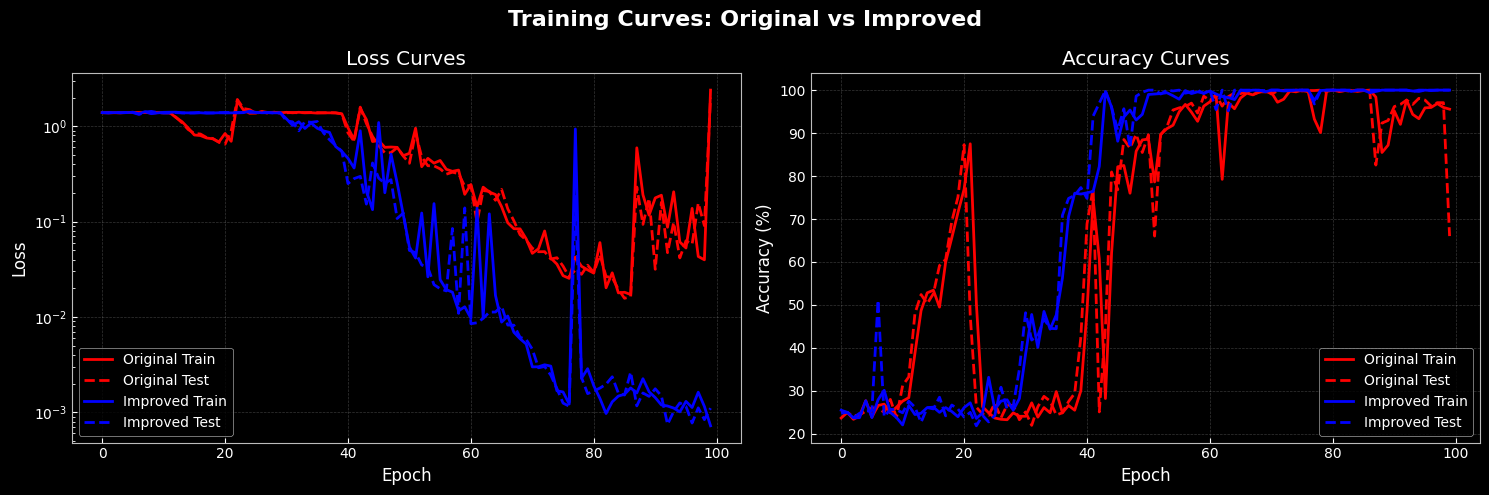

\n2. Gradient Analysis:


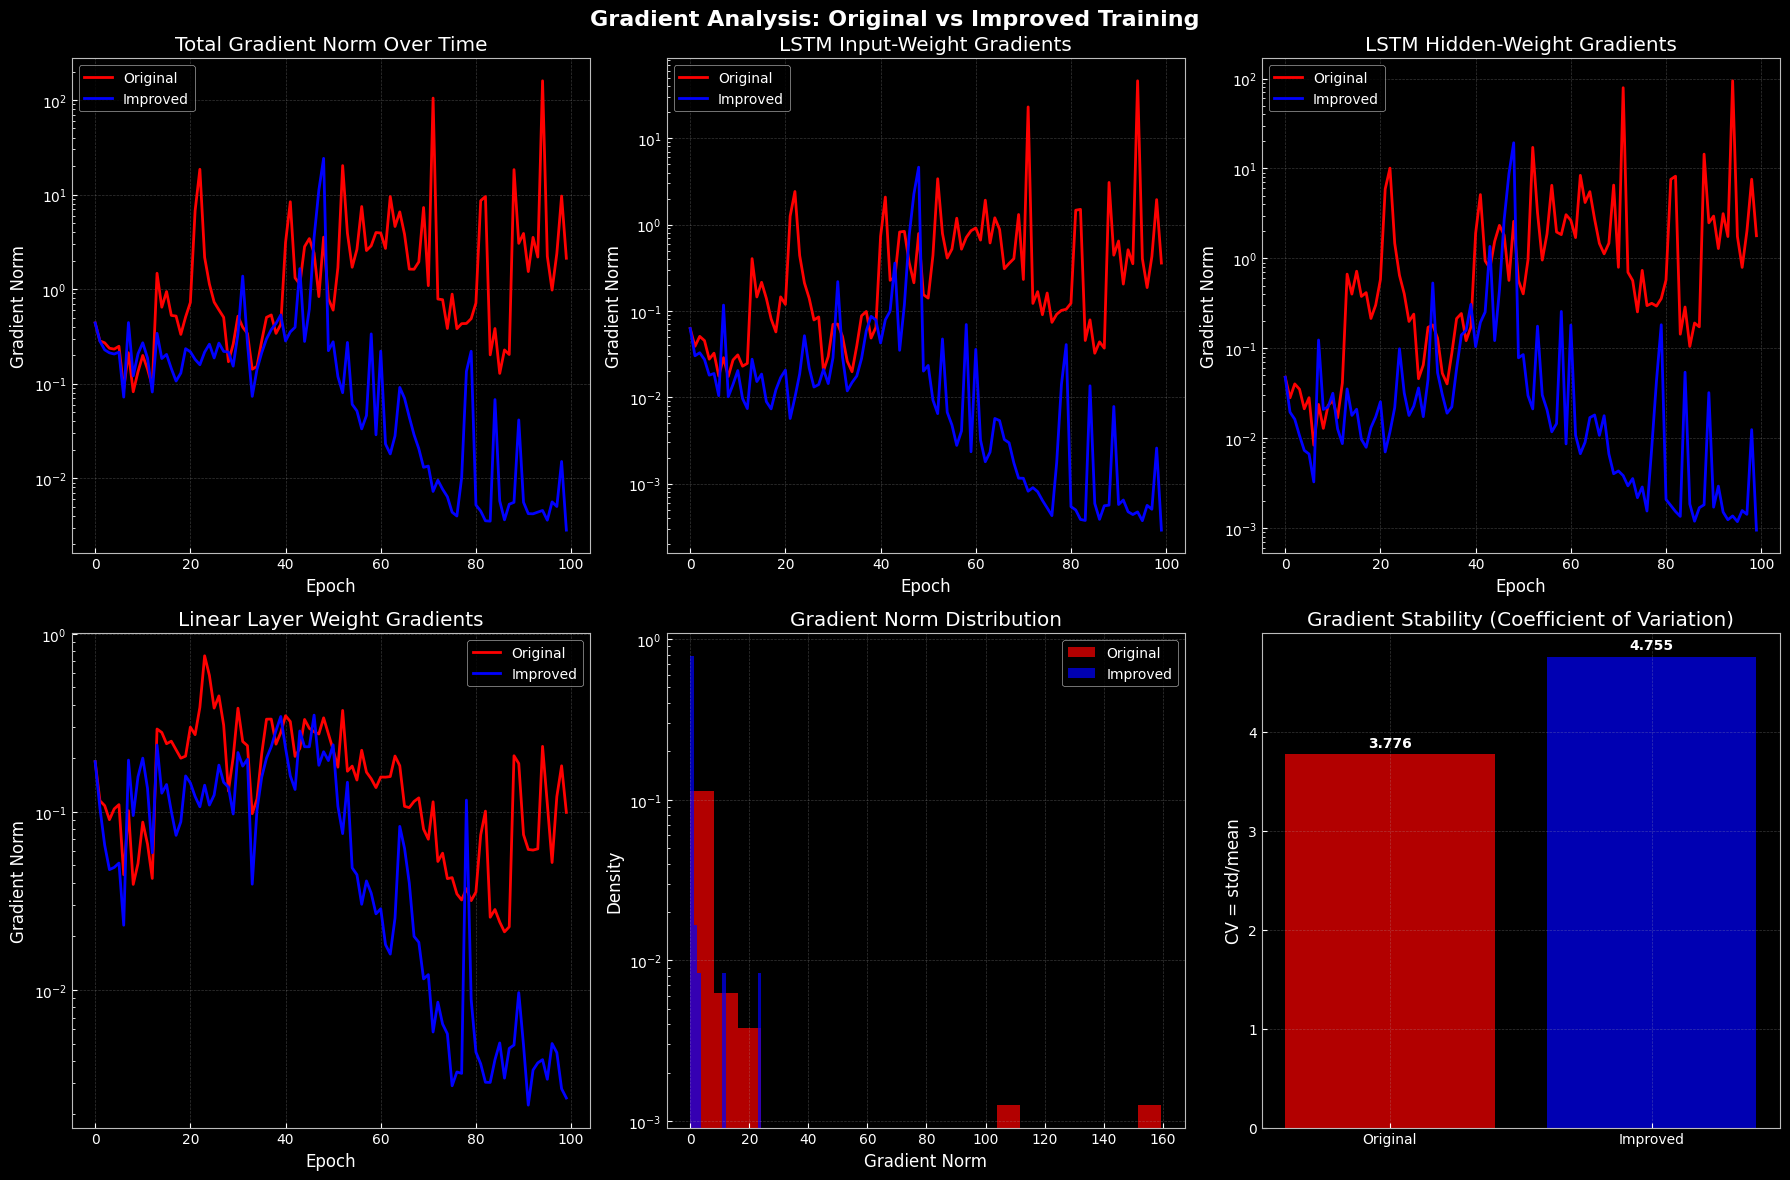

\n=== Gradient Statistics ===
Original - Max gradient norm: 159.5306, Mean: 5.0152, Std: 18.9392
Improved - Max gradient norm: 24.1405, Mean: 0.5554, Std: 2.6408
Gradient stability improvement: 0.79x more stable
\n3. Weight Analysis:


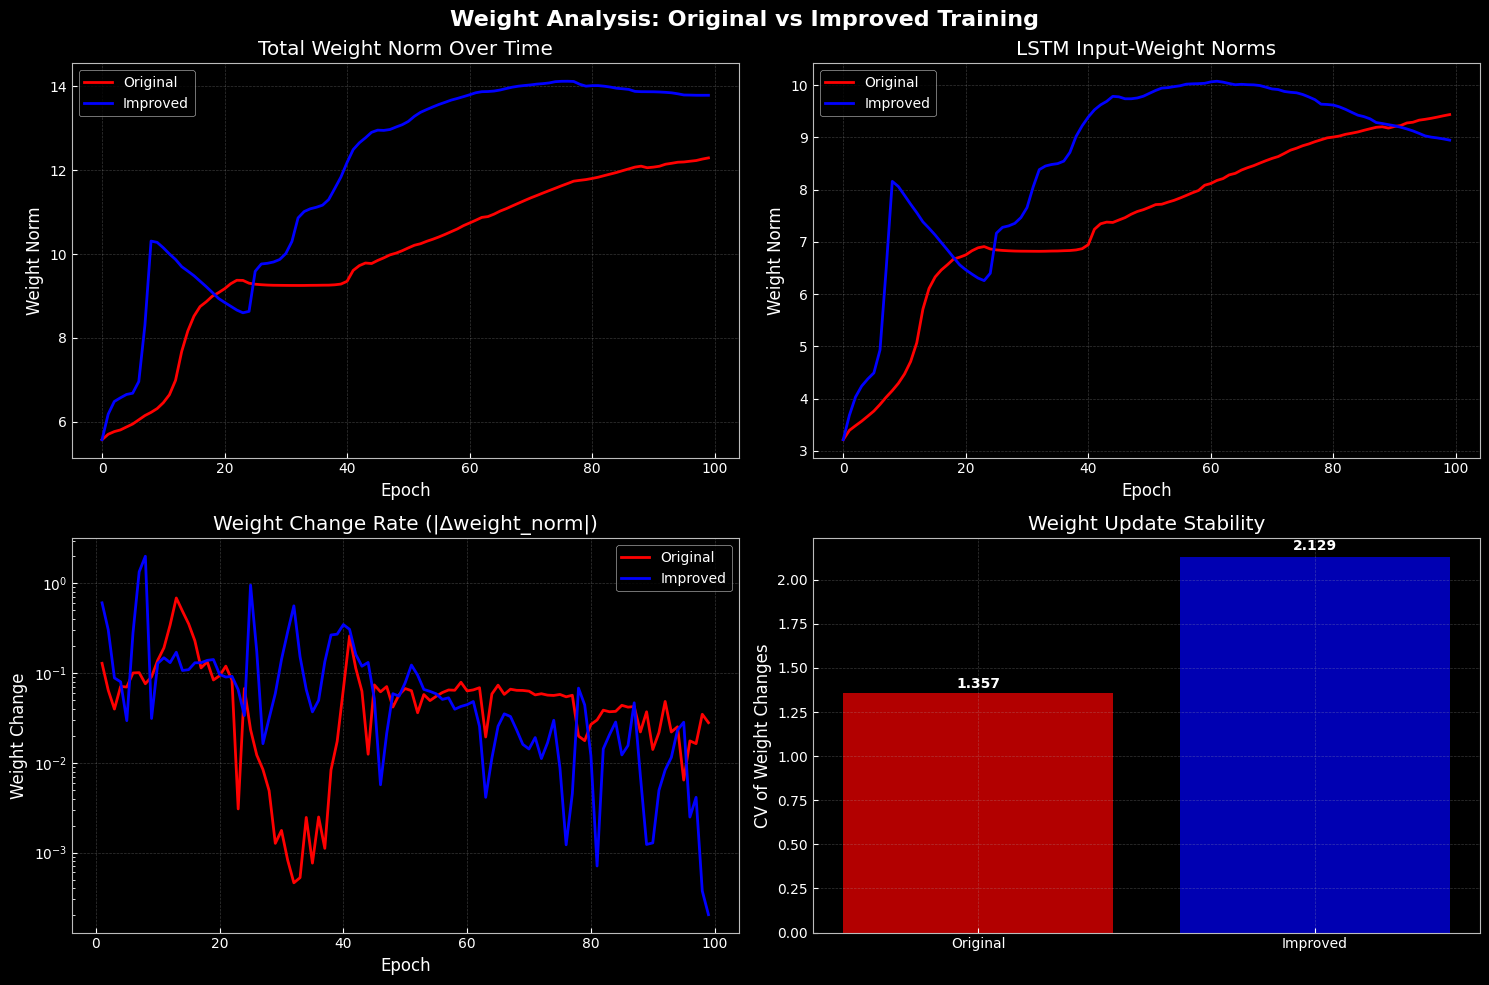

\n============================================================
SUMMARY STATISTICS
\nFinal Performance:
Original - Final Train Loss: 2.390399, Final Test Accuracy: 66.03%
Improved - Final Train Loss: 0.000722, Final Test Accuracy: 100.00%
\nTraining Stability:
Original - Loss spikes: 7
Improved - Loss spikes: 8
Spike reduction: -1 spikes eliminated
\nGradient Control:
Original - Max gradient norm: 159.5306
Improved - Max gradient norm: 24.1405
Gradient reduction: 6.61x smaller maximum gradients


In [33]:
# Generate comprehensive visualizations
print("\\n" + "="*60)
print("COMPREHENSIVE GRADIENT AND WEIGHT ANALYSIS")
print("="*60)

# 1. Training curves comparison
print("\\n1. Training Curves Comparison:")
plot_training_curves_comparison(history_original_train, history_original_test,
                               history_improved_train, history_improved_test)

# 2. Gradient analysis
print("\\n2. Gradient Analysis:")
plot_gradient_analysis(tracker_original, tracker_improved)

# 3. Weight analysis
print("\\n3. Weight Analysis:")
plot_weight_analysis(tracker_original, tracker_improved)

# 4. Summary statistics
print("\\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)

print("\\nFinal Performance:")
print(f"Original - Final Train Loss: {history_original_train['loss'][-1]:.6f}, Final Test Accuracy: {history_original_test['acc'][-1]:.2f}%")
print(f"Improved - Final Train Loss: {history_improved_train['loss'][-1]:.6f}, Final Test Accuracy: {history_improved_test['acc'][-1]:.2f}%")

# Calculate spike statistics
def count_spikes(values, threshold=2.0):
    """Count spikes above threshold"""
    spikes = 0
    for i in range(1, len(values)):
        if values[i] > threshold * values[i-1]:
            spikes += 1
    return spikes

orig_loss_spikes = count_spikes(history_original_train['loss'])
improved_loss_spikes = count_spikes(history_improved_train['loss'])

print(f"\\nTraining Stability:")
print(f"Original - Loss spikes: {orig_loss_spikes}")
print(f"Improved - Loss spikes: {improved_loss_spikes}")
print(f"Spike reduction: {orig_loss_spikes - improved_loss_spikes} spikes eliminated")

# Gradient statistics
orig_max_grad = max(tracker_original.gradient_norms['total'])
improved_max_grad = max(tracker_improved.gradient_norms['total'])

print(f"\\nGradient Control:")
print(f"Original - Max gradient norm: {orig_max_grad:.4f}")
print(f"Improved - Max gradient norm: {improved_max_grad:.4f}")
print(f"Gradient reduction: {orig_max_grad/improved_max_grad:.2f}x smaller maximum gradients")
